# Load Data files and Import Python Libraries

In [1]:
import numpy as np

import pandas as pd

import os

from sklearn.feature_selection import RFE

import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression

#import MatPlotLib
import matplotlib as mpl 

#Import PyPlot in MatPlotLib
import matplotlib.pyplot as plt 

#Import SciKitLearn decomposition PCA library
from sklearn.decomposition import PCA

#Import SciKitLearn dataset 
from sklearn import datasets as ds

#Allows for meterics to be found after Logistic Regression
from sklearn import metrics as mt

#Create KFolds for CV_Object
from sklearn.model_selection import StratifiedKFold

#Creates Standard Scaler Variables
from sklearn.preprocessing import StandardScaler

#Seaborn 
import seaborn as sb

directory = '//users/cmirwin/desktop/Capstone/'

if not os.path.exists(directory):
    os.makedirs(directory)

#Import Team Info
dfGameData = pd.read_csv(directory + 'GameData.csv', sep='|')

dfGameData.head()

/Users/cmirwin/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


,GameID,HomeTeam,AwayTeam,GameWinner,GameLoser,ScoreHome,ScoreAway,HomeFirstDowns,HomePassingYards,HomePenaltyCnt,...,WindChill,HeatIndex,HomePassYardsPerAttempt,HomePassingCompPct,AwayPassYardsPerAttempt,AwayPassingCompPct,HomeRushYardsPerAttempt,AwayRushYardsPerAttempt,HomeTeamWin,Degrees
0,1,PIT,TEN,PIT,TEN,13,10,19,321,6,...,NaN,NaN,9.727273,0.767442,10.636364,0.628571,1.565217,3.440000,1,67.5
1,2,ATL,MIA,ATL,MIA,19,7,19,213,4,...,NaN,NaN,9.681818,0.611111,7.761905,0.700000,2.518519,4.363636,1,90.0
2,3,BAL,KC,BAL,KC,38,24,32,303,8,...,NaN,NaN,11.653846,0.604651,9.937500,0.666667,4.829268,1.705882,1,0.0
3,4,CAR,PHI,PHI,CAR,10,38,14,83,5,...,NaN,81.0,5.928571,0.411765,4.823529,0.586207,2.866667,5.781250,0,22.5
4,5,CIN,DEN,DEN,CIN,7,12,16,221,4,...,NaN,NaN,10.523810,0.636364,13.352941,0.607143,3.185185,3.750000,0,67.5


 # Create Dummy Variables for Dataset

In [3]:
#Create new DataFrame for PCA
gameDataPCA = dfGameData
dummiesColumnToCreate = ['WindDir', 'Condition','TimeOfDay']

#Create Dummy Variables
for column in dummiesColumnToCreate:
    dummies = pd.get_dummies(gameDataPCA[str(column)]).rename(columns=lambda x: str(column) + '_' + str(x))
    #Join to Dataframe for Model
    gameDataPCA = pd.concat([gameDataPCA, dummies], axis=1)

dfPossionTime = pd.DataFrame(gameDataPCA[['HomePossTime','AwayPossTime']])

for loop in (0,1):
    location = 0
    for possTime in dfPossionTime.values:
        timeBreak = possTime[loop].split(':')
        minToSec = int(timeBreak[0]) * 60
        totalTimeinSec = minToSec + int(timeBreak[1])
        #print totalTimeinSec
        if loop == 0:
            gameDataPCA.loc[location, 'HomeTeamPossSec'] = totalTimeinSec
        else:
             gameDataPCA.loc[location, 'AwayTeamPossSec'] = totalTimeinSec
                
        location = location + 1

#Get columns that are only numeric in nature. 
columnsToDrop = ['HomeTeam', 'AwayTeam', 'GameWinner','GameLoser', 'WindDir', 'Condition','TimeOfDay', 'Date'
                 , 'HomePossTime', 'AwayPossTime']



#Drop Variables
gameDataPCA.drop(columnsToDrop, inplace=True, axis=1)

#Fill in Missing Values with 0
gameDataPCA.fillna(0, inplace=True)

gameDataPCA.head()

,GameID,ScoreHome,ScoreAway,HomeFirstDowns,HomePassingYards,HomePenaltyCnt,HomePenaltyYards,HomePuntAvg,HomepuntCnt,HomePuntYards,...,TimeOfDay_7:20,TimeOfDay_7:30,TimeOfDay_8:00,TimeOfDay_8:20,TimeOfDay_8:25,TimeOfDay_8:30,TimeOfDay_8:40,TimeOfDay_9:30,HomeTeamPossSec,AwayTeamPossSec
0,1,13,10,19,321,6,60,41,7,299,...,0,0,0,0,0,1,0,0,2171.0,1701.0
1,2,19,7,19,213,4,35,31,4,155,...,0,0,0,0,0,0,0,0,1853.0,1747.0
2,3,38,24,32,303,8,65,29,3,87,...,0,0,0,0,0,0,0,0,2389.0,1211.0
3,4,10,38,14,83,5,30,19,4,223,...,0,0,0,0,0,0,0,0,1703.0,1897.0
4,5,7,12,16,221,4,27,37,7,278,...,0,0,0,0,0,0,0,0,2007.0,1593.0


# Feature Selection
## Recursive Feature Elimination

In [5]:
gameDataVariables = gameDataPCA.columns.values.tolist()
y = gameDataPCA['HomeTeamWin']
X=[i for i in gameDataVariables if i not in y]

logreg = LogisticRegression()
rfe = RFE(logreg, 100)
rfe = rfe.fit(gameDataPCA[X], y )

dfColumns = pd.DataFrame(X)

dfRankings = pd.DataFrame(rfe.ranking_)

dfColumnResults =  pd.concat([dfRankings, dfColumns], axis=1, join_axes=[dfRankings.index])

dfColumnResults.columns = ['Value', 'ColumnName']

dfColumnsForModel = dfColumnResults[dfColumnResults['Value'] == 1]

print dfColumnsForModel['ColumnName'].values

['GameID' 'ScoreHome' 'ScoreAway' 'HomeFirstDowns' 'HomePassingYards'
 'HomePenaltyCnt' 'HomePenaltyYards' 'HomePuntAvg' 'HomepuntCnt'
 'HomePuntYards' 'HomeRushingYards' 'HomeTotalYards' 'HomeTurnOvers'
 'AwayFirstDowns' 'AwayPassingYards' 'AwayPenaltyCnt' 'AwayPenaltyYards'
 'AwayPuntAvg' 'AwaypuntCnt' 'AwayPuntYards' 'AwayRushingYards'
 'AwayTotalYards' 'AwayTurnOvers' 'HomeFieldGoals' 'AwayFieldGoals'
 'HomeTouchDowns' 'AwayTouchDowns' 'HomePassingComp' 'AwayPassingComp'
 'HomePassingAtt' 'AwayPassingAtt' 'HomePassingTD' 'AwayPassingTD'
 'HomeRushingAtt' 'AwayRushingAtt' 'HomeRushingTD' 'AwayRushingTD' 'Week'
 'Day' 'NumericDate' 'Temp' 'DewPoint' 'Visiability' 'Humidity'
 'WindSpeed' 'Pressure' 'Rain' 'Snow' 'WindChill' 'HeatIndex'
 'HomePassYardsPerAttempt' 'HomePassingCompPct' 'AwayPassYardsPerAttempt'
 'AwayPassingCompPct' 'HomeRushYardsPerAttempt' 'AwayRushYardsPerAttempt'
 'HomeTeamWin' 'Degrees' 'WindDir_ENE' 'WindDir_ESE' 'WindDir_East'
 'WindDir_NE' 'WindDir_NNE' 'WindDir_

## PCA Analysis

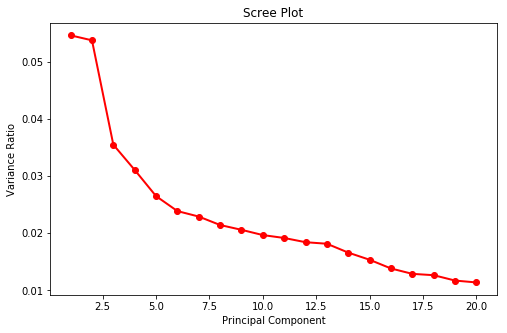

In [25]:
#This section scales the data in order to create a more useable data set
# scale attributes by the training set
stdsclrObj = StandardScaler()

# find scalings for each column that make this zero mean and unit std
#We use the training data to help fit the standard dev
# find scalings for each column that make this zero mean and unit std
stdsclrObj.fit(gameDataPCA) 

# to transform new feature data
# apply to training
gameData_scaled = stdsclrObj.transform(gameDataPCA)

components = 20

pca = PCA(n_components= components)

#Run PCA
# fit data and then transform it
gameData_pca = pca.fit(gameData_scaled).transform(gameData_scaled) 

variance_ratio = pca.explained_variance_ratio_

fig = plt.figure(figsize=(8,5))
#Create 
CompentValues = np.arange(components) + 1
plt.plot(CompentValues, variance_ratio, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Ratio')
plt.show()

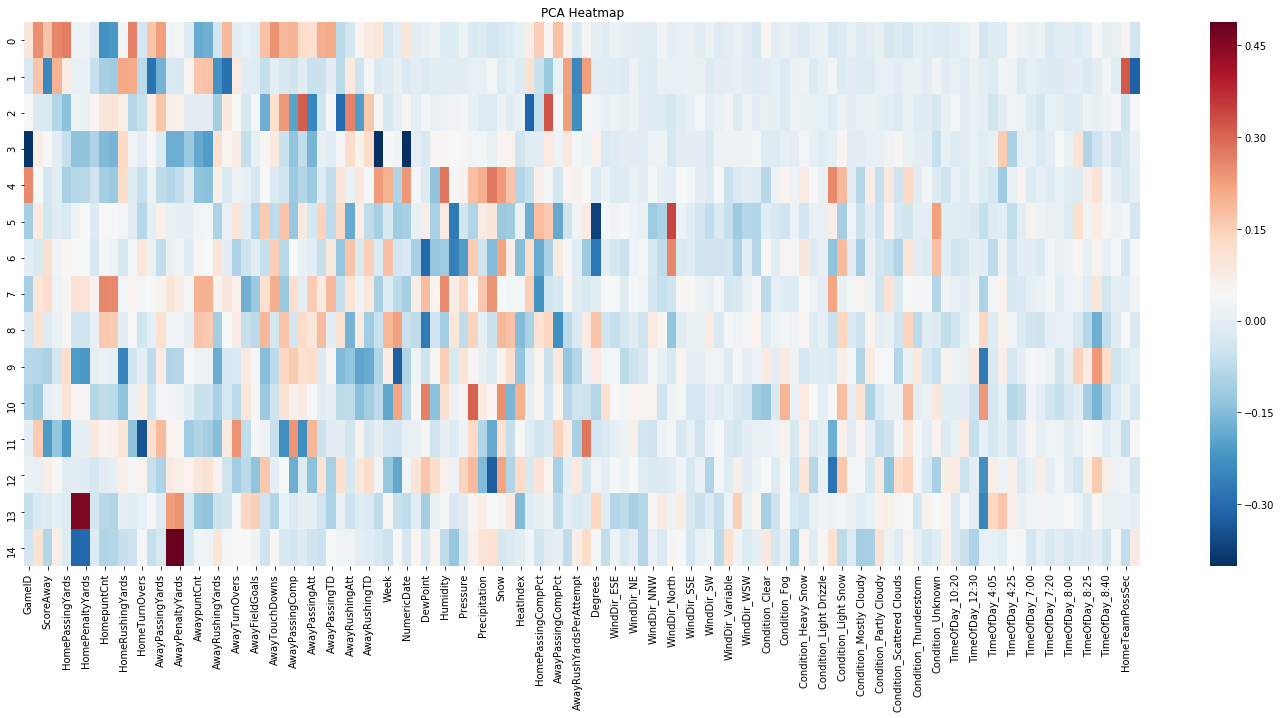

In [26]:
pca_components = pca.components_

compValues = pd.DataFrame(pca_components,columns=gameDataPCA.columns)

#show top 40 vectors due to the analysis 
compValues = compValues[compValues.index < 15]

plt.figure(figsize=(25,10))

plt.title('PCA Heatmap')

sb.heatmap(compValues, cmap = 'RdBu_r', cbar=True)

plt.show()

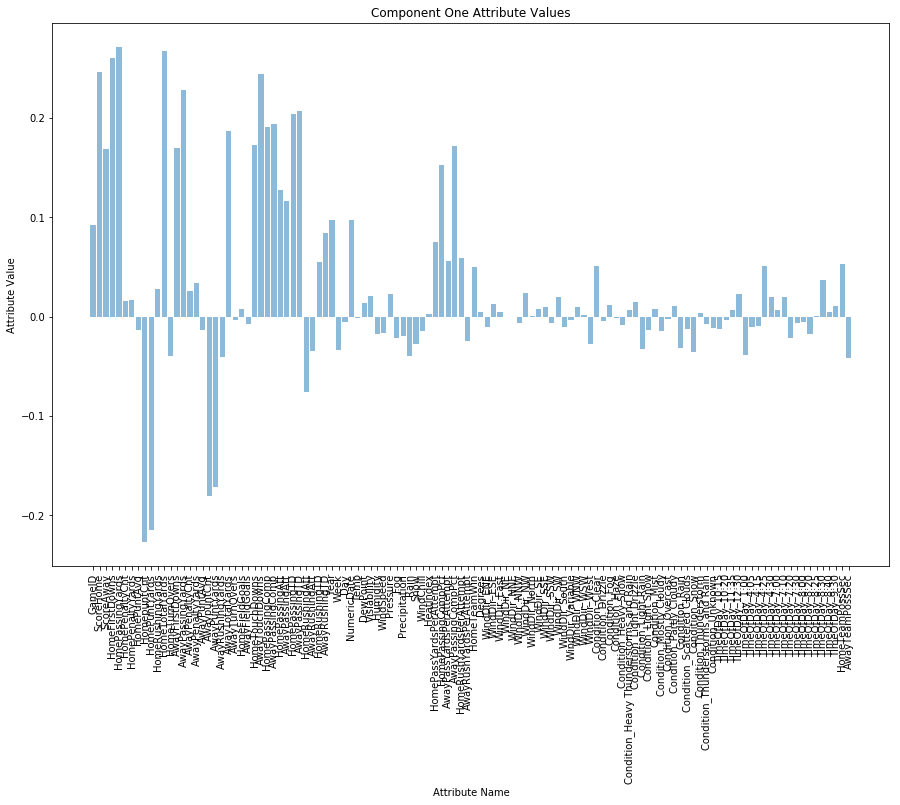

In [27]:
compValuesTransformed = compValues.T

#print (compValuesTransformed[0])

fig = plt.figure(figsize=(15,10))
#Create
objects = compValuesTransformed.index
y_pos = np.arange(len(objects)) + 1
performance = compValuesTransformed[0]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation=90)
plt.xlabel('Attribute Name')
plt.ylabel('Attribute Value')
plt.title('Component One Attribute Values')

plt.show()

# Creating Logistic Regression Model
https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

## Create X and Y for model using all columns 

In [28]:
dfValuesForRegression = pd.DataFrame()

for column in gameDataPCA.columns:
    if column not in ('ScoreHome', 'ScoreAway', 'HomeTeamWin'):
        dfValuesForRegression[column] = gameDataPCA[[column]] 

y = gameDataPCA['HomeTeamWin']

XFull = dfValuesForRegression

XFull.head()

,GameID,HomeFirstDowns,HomePassingYards,HomePenaltyCnt,HomePenaltyYards,HomePuntAvg,HomepuntCnt,HomePuntYards,HomeRushingYards,HomeTotalYards,...,TimeOfDay_7:20,TimeOfDay_7:30,TimeOfDay_8:00,TimeOfDay_8:20,TimeOfDay_8:25,TimeOfDay_8:30,TimeOfDay_8:40,TimeOfDay_9:30,HomeTeamPossSec,AwayTeamPossSec
0,1,19,321,6,60,41,7,299,36,357,...,0,0,0,0,0,1,0,0,2171.0,1701.0
1,2,19,213,4,35,31,4,155,68,281,...,0,0,0,0,0,0,0,0,1853.0,1747.0
2,3,32,303,8,65,29,3,87,198,501,...,0,0,0,0,0,0,0,0,2389.0,1211.0
3,4,14,83,5,30,19,4,223,86,169,...,0,0,0,0,0,0,0,0,1703.0,1897.0
4,5,16,221,4,27,37,7,278,86,307,...,0,0,0,0,0,0,0,0,2007.0,1593.0


## Create X and Y for  Recursive

In [29]:
dfRecursiveForRegression = pd.DataFrame()

for column in dfColumnsForModel['ColumnName'].values:
    if column not in ('ScoreHome', 'ScoreAway', 'HomeTeamWin'):
        dfRecursiveForRegression[column] = gameDataPCA[[column]] 

y = gameDataPCA['HomeTeamWin']

XRecursive = dfRecursiveForRegression

XRecursive.head()

,GameID,HomeFirstDowns,HomePassingYards,HomePenaltyCnt,HomePenaltyYards,HomePuntAvg,HomepuntCnt,HomePuntYards,HomeRushingYards,HomeTotalYards,...,TimeOfDay_1:00,TimeOfDay_4:05,TimeOfDay_4:15,TimeOfDay_4:25,TimeOfDay_8:20,TimeOfDay_8:30,TimeOfDay_8:40,TimeOfDay_9:30,HomeTeamPossSec,AwayTeamPossSec
0,1,19,321,6,60,41,7,299,36,357,...,0,0,0,0,0,1,0,0,2171.0,1701.0
1,2,19,213,4,35,31,4,155,68,281,...,1,0,0,0,0,0,0,0,1853.0,1747.0
2,3,32,303,8,65,29,3,87,198,501,...,1,0,0,0,0,0,0,0,2389.0,1211.0
3,4,14,83,5,30,19,4,223,86,169,...,1,0,0,0,0,0,0,0,1703.0,1897.0
4,5,16,221,4,27,37,7,278,86,307,...,1,0,0,0,0,0,0,0,2007.0,1593.0


## Create data set for PCA Values

In [30]:
#Get All PCA Data
dfPCAValues = pd.DataFrame(performance)

#Set Column Names for dataframe created above
dfPCAValues.columns = ['values']

#Get all Columns with an absolute value greater than .05
dfColumnNamesForRegression = dfPCAValues[abs(dfPCAValues['values']) > .05]

#Create new Data frame with Correct Column Names.
dfColumnName = pd.DataFrame(dfColumnNamesForRegression.index, columns = ['ColumnName'])

#Create empty dataFrame for column values
dfColValuesForRegression = pd.DataFrame()

#Fill new dataFrame
for column in dfColumnName.values:
    insertColumn = column[-1]
    if insertColumn not in ('ScoreHome', 'ScoreAway'):
        dfColValuesForRegression[insertColumn] = gameDataPCA[[insertColumn]] 
    
y = gameDataPCA['HomeTeamWin']

XPCA = dfColValuesForRegression

XPCA.head()

,GameID,HomeFirstDowns,HomePassingYards,HomepuntCnt,HomePuntYards,HomeTotalYards,AwayFirstDowns,AwayPassingYards,AwaypuntCnt,AwayPuntYards,...,Year,NumericDate,HomePassYardsPerAttempt,HomePassingCompPct,AwayPassYardsPerAttempt,AwayPassingCompPct,HomeRushYardsPerAttempt,Condition_Clear,TimeOfDay_4:25,HomeTeamPossSec
0,1,19,321,7,299,357,18,234,5,223,...,2009,20090910,9.727273,0.767442,10.636364,0.628571,1.565217,1,0,2171.0
1,2,19,213,4,155,281,16,163,5,225,...,2009,20090913,9.681818,0.611111,7.761905,0.700000,2.518519,1,0,1853.0
2,3,32,303,3,87,501,11,159,5,246,...,2009,20090913,11.653846,0.604651,9.937500,0.666667,4.829268,0,0,2389.0
3,4,14,83,4,223,169,17,82,4,171,...,2009,20090913,5.928571,0.411765,4.823529,0.586207,2.866667,0,0,1703.0
4,5,16,221,7,278,307,10,227,8,340,...,2009,20090913,10.523810,0.636364,13.352941,0.607143,3.185185,1,0,2007.0


## Create Model and Cross Validation Object

In [31]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.model_selection import ShuffleSplit
   
#Create CV_Object
cv_object = ShuffleSplit(n_splits=10,
                         test_size  = .1)


accPerRun = pd.DataFrame();



## Model and Cross Validation for PCA Suggestions

In [39]:

# first we create a reusable logisitic regression object
# get object
lr_clfPCA = LogisticRegression(penalty='l1', C=1.0, class_weight=None) 

# train object
lr_clfPCA.fit(XPCA,y)

# get test set precitions
y_hat = lr_clfPCA.predict(XPCA) 

#print('Intercept: ', clf.intercept_, 'Coeffiencts: ', clf.coef_)

#Get Accuracy_Score and Confusion Matrix
acc = mt.accuracy_score(y,y_hat)
conf = mt.confusion_matrix(y,y_hat)
print("==== Model Fit PCA Data Set ====")
print("Full Model accuracy", acc )
#print("confusion matrix\n",conf)

iter_num = 1
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(XPCA,y): 
  
    #Create Training DataSet
    X_train = XPCA.loc[XPCA.index.isin(train_indices)]
    y_train = y.loc[y.index.isin(train_indices)] 
    
    #Create Testing DataSet
    X_test = XPCA.loc[XPCA.index.isin(test_indices)]
    y_test = y.loc[y.index.isin(test_indices)]
    
    # train object
    lr_clfPCA.fit(X_train,y_train)
    
    # get test set precitions
    y_hat = lr_clfPCA.predict(X_test) 

    #Get Accuracy_Score and Confusion Matrix
    acc = mt.accuracy_score(y_test,y_hat)
    #conf = mt.confusion_matrix(y_test,y_hat)
    #print("==== Cross Validation Iteration",iter_num," ====")
    print("accuracy" , iter_num , acc )
    #print("confusion matrix\n",conf)
    iter_num+=1
    
    accPerRun.loc[iter_num - 1, 'PCAModelAcc'] = acc

==== Model Fit PCA Data Set ====
('Full Model accuracy', 0.7060969254820219)
('accuracy', 1, 0.609375)
('accuracy', 2, 0.6354166666666666)
('accuracy', 3, 0.7083333333333334)
('accuracy', 4, 0.7083333333333334)
('accuracy', 5, 0.703125)
('accuracy', 6, 0.7135416666666666)
('accuracy', 7, 0.703125)
('accuracy', 8, 0.6614583333333334)
('accuracy', 9, 0.6614583333333334)
('accuracy', 10, 0.7083333333333334)


## Create Model for Recursive Data 

In [58]:
# first we create a reusable logisitic regression object
# get object
lr_clfRecursive = LogisticRegression(penalty='l1', C=1.0, class_weight=None) 

lr_clfRecursive.fit(XRecursive,y)

# get test set precitions
y_hat = lr_clfRecursive.predict(XRecursive) 

#print('Intercept: ', clf.intercept_, 'Coeffiencts: ', clf.coef_)

#Get Accuracy_Score and Confusion Matrix
acc = mt.accuracy_score(y,y_hat)
conf = mt.confusion_matrix(y,y_hat)
print("==== Model Fit Recursive Data Set ====")
print("accuracy", acc )
print("confusion matrix\n",conf)

iter_num = 1
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(XRecursive,y): 
  
    #Create Training DataSet
    X_train = XRecursive.loc[XRecursive.index.isin(train_indices)]
    y_train = y.loc[y.index.isin(train_indices)] 
    
    #Create Testing DataSet
    X_test = XRecursive.loc[XRecursive.index.isin(test_indices)]
    y_test = y.loc[y.index.isin(test_indices)]
    
    # train object
    lr_clfRecursive.fit(X_train,y_train)
    
    # get test set precitions
    y_hat = lr_clfRecursive.predict(X_test) 

    #Get Accuracy_Score and Confusion Matrix
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("==== Cross Validation Iteration",iter_num," ====")
    print("accuracy", acc )
    #print("confusion matrix\n",conf)
    iter_num+=1
    accPerRun.loc[iter_num - 1, 'RecursiveModelAcc'] = acc

==== Model Fit Recursive Data Set ====
('accuracy', 0.8509640437727983)
('confusion matrix\n', array([[677, 157],
       [129, 956]]))
('==== Cross Validation Iteration', 1, ' ====')
('accuracy', 0.8489583333333334)
('==== Cross Validation Iteration', 2, ' ====')
('accuracy', 0.8125)
('==== Cross Validation Iteration', 3, ' ====')
('accuracy', 0.859375)
('==== Cross Validation Iteration', 4, ' ====')
('accuracy', 0.8333333333333334)
('==== Cross Validation Iteration', 5, ' ====')
('accuracy', 0.8333333333333334)
('==== Cross Validation Iteration', 6, ' ====')
('accuracy', 0.8489583333333334)
('==== Cross Validation Iteration', 7, ' ====')
('accuracy', 0.8125)
('==== Cross Validation Iteration', 8, ' ====')
('accuracy', 0.8072916666666666)
('==== Cross Validation Iteration', 9, ' ====')
('accuracy', 0.8385416666666666)
('==== Cross Validation Iteration', 10, ' ====')
('accuracy', 0.8541666666666666)


## Cross Validation for Full Dataset model

In [57]:
# first we create a reusable logisitic regression object
# get object
lr_clfFM = LogisticRegression(penalty='l1', C=1.0, class_weight=None) 

# train object
lr_clfFM.fit(XFull,y)

# get test set precitions
y_hat = lr_clfFM.predict(XFull) 

#print('Intercept: ', clf.intercept_, 'Coeffiencts: ', clf.coef_)

#Get Accuracy_Score and Confusion Matrix
acc = mt.accuracy_score(y,y_hat)
conf = mt.confusion_matrix(y,y_hat)
print("==== Model Fit Full Data Set ====")
print("accuracy", acc )
print("confusion matrix\n",conf)

iter_num = 1
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(XFull,y): 
  
    #Create Training DataSet
    X_train = XFull.loc[XFull.index.isin(train_indices)]
    y_train = y.loc[y.index.isin(train_indices)] 
    
    #Create Testing DataSet
    X_test = XFull.loc[XFull.index.isin(test_indices)]
    y_test = y.loc[y.index.isin(test_indices)]
    
    # train object
    lr_clfFM.fit(X_train,y_train)
    
    # get test set precitions
    y_hat = lr_clfFM.predict(X_test) 

    #Get Accuracy_Score and Confusion Matrix
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("==== Cross Validation Iteration",iter_num," ====")
    print("accuracy", acc )
    #print("confusion matrix\n",conf)
    iter_num+=1
    
    accPerRun.loc[iter_num - 1, 'FullModelAccuracy'] = acc

==== Model Fit Full Data Set ====
('accuracy', 0.853048462741011)
('confusion matrix\n', array([[681, 153],
       [129, 956]]))
('==== Cross Validation Iteration', 1, ' ====')
('accuracy', 0.8541666666666666)
('==== Cross Validation Iteration', 2, ' ====')
('accuracy', 0.921875)
('==== Cross Validation Iteration', 3, ' ====')
('accuracy', 0.8541666666666666)
('==== Cross Validation Iteration', 4, ' ====')
('accuracy', 0.7916666666666666)
('==== Cross Validation Iteration', 5, ' ====')
('accuracy', 0.828125)
('==== Cross Validation Iteration', 6, ' ====')
('accuracy', 0.8489583333333334)
('==== Cross Validation Iteration', 7, ' ====')
('accuracy', 0.859375)
('==== Cross Validation Iteration', 8, ' ====')
('accuracy', 0.8125)
('==== Cross Validation Iteration', 9, ' ====')
('accuracy', 0.8072916666666666)
('==== Cross Validation Iteration', 10, ' ====')
('accuracy', 0.8229166666666666)


# Model Results for 10 different Runs

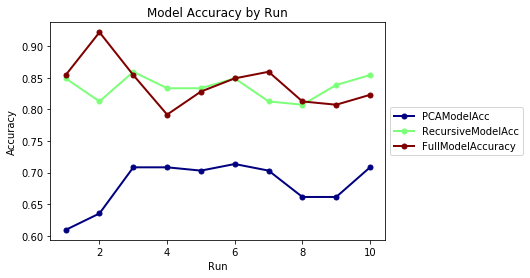

In [59]:

f = plt.figure()

ax = accPerRun.plot(lw=2,colormap='jet',marker='.',markersize=10,title='Model Accuracy by Run')

ax.set_xlabel("Run")

ax.set_ylabel("Accuracy")

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.show()




# Load 2017 Data 

In [12]:
dfGameData = pd.read_csv(directory + '2017Games.csv', sep=',')


# Create Dummy variables 

In [13]:
#Create new DataFrame for PCA
gameData2017 = dfGameData

#Get Original Results
gameResults = dfGameData[['GameID', 'HomeTeamWin']]

dummiesColumnToCreate = ['WindDir', 'Condition','TimeOfDay']

#Create Dummy Variables
for column in dummiesColumnToCreate:
    dummies = pd.get_dummies(gameData2017[str(column)]).rename(columns=lambda x: str(column) + '_' + str(x))
    #Join to Dataframe for Model
    gameData2017 = pd.concat([gameData2017, dummies], axis=1)

#update Time Columns
gameData2017['HomeTeamPossSec'] = gameData2017['HomePossTime']

gameData2017['AwayTeamPossSec'] = gameData2017['AwayPossTime']    
    
#Fill in Missing Values with 0
gameData2017.fillna(0, inplace=True)

newFileNames = pd.DataFrame(gameData2017.columns)

origFileNames = pd.DataFrame(gameDataPCA.columns)

dfMissingColumns = origFileNames[~origFileNames[0].isin(newFileNames[0])]

for column in dfMissingColumns[0]:
    gameData2017[column] = 0
    
#Get columns that are only numeric in nature. 
columnsToDrop = ['HomeTeam', 'AwayTeam', 'WindDir', 'Condition','TimeOfDay', 'Date'
                 , 'HomePossTime', 'AwayPossTime','ScoreHome', 'ScoreAway', 'HomeTeamWin']

#Drop Variables
gameData2017.drop(columnsToDrop, inplace=True, axis=1)


dfgameData2017FM = pd.DataFrame()

#Fill new dataFrame
for column in XFull.columns:
    insertColumn = column
    dfgameData2017FM[insertColumn] = gameData2017[[insertColumn]] 
    
dfgameData2017FM.head()


,GameID,HomeFirstDowns,HomePassingYards,HomePenaltyCnt,HomePenaltyYards,HomePuntAvg,HomepuntCnt,HomePuntYards,HomeRushingYards,HomeTotalYards,...,TimeOfDay_7:20,TimeOfDay_7:30,TimeOfDay_8:00,TimeOfDay_8:20,TimeOfDay_8:25,TimeOfDay_8:30,TimeOfDay_8:40,TimeOfDay_9:30,HomeTeamPossSec,AwayTeamPossSec
0,1,25,247,6,55,39,6,242,124,371,...,0,0,0,0,0,1,0,0,1786,1814
1,2,23,218,6,50,35,6,257,190,408,...,0,0,0,0,0,0,0,0,1984,1616
2,3,20,176,4,40,40,5,244,125,301,...,0,0,0,0,0,0,0,0,1766,1834
3,4,14,144,9,66,38,5,212,77,221,...,0,0,0,0,0,0,0,0,1560,2040
4,5,20,180,4,61,30,6,242,57,237,...,0,0,0,0,0,0,0,0,1870,1730


## Remove columns for PCA Fitting

In [201]:
dfgameData2017PCA = pd.DataFrame()

#Fill new dataFrame
for column in XPCA.columns:
    insertColumn = column
    dfgameData2017PCA[insertColumn] = gameData2017[[insertColumn]] 
    
dfgameData2017PCA.head()

,GameID,HomeFirstDowns,HomePassingYards,HomepuntCnt,HomePuntYards,HomeTotalYards,AwayFirstDowns,AwayPassingYards,AwaypuntCnt,AwayPuntYards,...,Year,NumericDate,HomePassYardsPerAttempt,HomePassingCompPct,AwayPassYardsPerAttempt,AwayPassingCompPct,HomeRushYardsPerAttempt,Condition_Clear,TimeOfDay_4:25,HomeTeamPossSec
0,1,25,247,6,242,371,26,352,6,262,...,2017,20170907,8.821429,0.800000,22.000000,0.444444,4.592593,1,0,1786
1,2,23,218,6,257,408,11,176,6,297,...,2017,20170910,13.625000,0.571429,6.769231,0.666667,4.523810,1,0,1984
2,3,20,176,5,244,301,18,308,3,178,...,2017,20170910,8.380952,0.700000,11.846154,0.650000,5.434783,0,0,1766
3,4,14,144,5,212,221,17,111,6,250,...,2017,20170910,16.000000,0.529412,6.937500,0.516129,1.833333,0,0,1560
4,5,20,180,6,242,237,16,255,6,275,...,2017,20170910,9.000000,0.666667,10.625000,0.666667,2.280000,1,0,1870


## Remove columns for Recursive Fitting

In [14]:
dfgameData2017Recursive = pd.DataFrame()

#Fill new dataFrame
for column in XRecursive.columns:
    insertColumn = column
    dfgameData2017Recursive[insertColumn] = gameData2017[[insertColumn]] 
    
dfgameData2017Recursive.head()

,GameID,HomeFirstDowns,HomePassingYards,HomePenaltyCnt,HomePenaltyYards,HomePuntAvg,HomepuntCnt,HomePuntYards,HomeRushingYards,HomeTotalYards,...,TimeOfDay_1:00,TimeOfDay_4:05,TimeOfDay_4:15,TimeOfDay_4:25,TimeOfDay_8:20,TimeOfDay_8:30,TimeOfDay_8:40,TimeOfDay_9:30,HomeTeamPossSec,AwayTeamPossSec
0,1,25,247,6,55,39,6,242,124,371,...,0,0,0,0,0,1,0,0,1786,1814
1,2,23,218,6,50,35,6,257,190,408,...,1,0,0,0,0,0,0,0,1984,1616
2,3,20,176,4,40,40,5,244,125,301,...,1,0,0,0,0,0,0,0,1766,1834
3,4,14,144,9,66,38,5,212,77,221,...,1,0,0,0,0,0,0,0,1560,2040
4,5,20,180,4,61,30,6,242,57,237,...,1,0,0,0,0,0,0,0,1870,1730


In [15]:
# get test set precitions
y_hatFM = lr_clfFM.predict(dfgameData2017FM)
gameResults['HomeTeamWinFM'] = y_hatFM

gameResults['FMCorrect'] = gameResults['HomeTeamWin'] == gameResults['HomeTeamWinFM']

# get test set precitions
y_hatPCA = lr_clfPCA.predict(dfgameData2017PCA)
gameResults['HomeTeamWinPCA'] = y_hatPCA

gameResults['PCACorrect'] = gameResults['HomeTeamWin'] == gameResults['HomeTeamWinPCA']

# get test set precitions
y_hatRecursive = lr_clfRecursive.predict(dfgameData2017Recursive)
gameResults['HomeTeamWinResursive'] = y_hatRecursive

gameResults['ResursiveCorrect'] = gameResults['HomeTeamWin'] == gameResults['HomeTeamWinResursive']


/Users/cmirwin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/cmirwin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


NameError: name 'lr_clfPCA' is not defined

In [205]:

gameResults.head()


,GameID,HomeTeamWin,HomeTeamWinFM,FMCorrect,HomeTeamWinPCA,PCACorrect,HomeTeamWinResursive,ResursiveCorrect
0,1,0,1,False,0,True,1,False
1,2,1,1,True,1,True,1,True
2,3,0,1,False,1,False,1,False
3,4,0,0,True,0,True,0,True
4,5,0,1,False,1,False,1,False


In [206]:
results = pd.DataFrame(gameResults)
results.to_csv(directory + '2017Results3Week.csv', sep='|', encoding='utf-8', index=False)  